### Example of LSTM and GRU - IMDB dataset

Loading and pre-processing dataset

In [159]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import models
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM, Dense, Embedding
from sklearn.model_selection import train_test_split
import pandas as pd

dataset = pd.read_csv('../merged_treinofinal.csv')

dataset['dif'] = dataset['goals_home'] - dataset['goals_away']
dataset.loc[dataset['dif'] > 0, 'result'] = '0'
dataset.loc[dataset['dif'] == 0, 'result'] = '1'
dataset.loc[dataset['dif'] < 0, 'result'] = '2'
dataset.loc[dataset['result'] == '0', 'home_Points'] = 3
dataset.loc[dataset['result'] == '1', 'home_Points'] = 1
dataset.loc[dataset['result'] == '2', 'home_Points'] = 0
dataset.loc[dataset['result'] == '2', 'away_Points'] = 3
dataset.loc[dataset['result'] == '1', 'away_Points'] = 1
dataset.loc[dataset['result'] == '0', 'away_Points'] = 0



In [7]:
jogadores_col = ['jogador1_home', 'jogador2_home', 'jogador3_home', 'jogador4_home',
'jogador5_home', 'jogador6_home', 'jogador7_home', 'jogador8_home',
'jogador9_home', 'jogador10_home', 'jogador11_home', 'jogador12_home',
'jogador13_home', 'jogador14_home', 'jogador15_home', 'jogador16_home',
'jogador17_home', 'jogador1_away', 'jogador2_away', 'jogador3_away',
'jogador4_away', 'jogador5_away', 'jogador6_away', 'jogador7_away',
'jogador8_away', 'jogador9_away', 'jogador10_away', 'jogador11_away',
'jogador12_away', 'jogador13_away', 'jogador14_away', 'jogador15_away',
'jogador16_away', 'jogador17_away', 'jogador18_home', 'jogador18_away', 'jogador19_away',
'jogador19_home', 'jogador20_away', 'jogador20_home']

dataset.drop(jogadores_col, axis=1, inplace=True)

In [6]:
dataset.columns

Index(['Jornada', 'Dia', 'Data', 'Horário', 'home', 'xG_home', 'xG_away',
       'away', 'Assistance', 'Local', 'Árbitro', 'Relatório da Partida',
       'goals_home', 'goals_away', 'formacao_home', 'formacao_away',
       'Faltas_home', 'Faltas_away', 'Escanteios_home', 'Escanteios_away',
       'Cruzamentos_home', 'Cruzamentos_away', 'Contatos_home',
       'Contatos_away', 'Bote defensivo_home', 'Bote defensivo_away',
       'Cortes_home', 'Cortes_away', 'Defesas_home', 'Defesas_away',
       'Impedimentos_home', 'Impedimentos_away', 'Tiro de meta_home',
       'Tiro de meta_away', 'Bolas longas_home', 'Bolas longas_away',
       'yellow_card_home', 'red_card_home', 'yellow_red_card_home',
       'yellow_card_away', 'red_card_away', 'yellow_red_card_away', 'HS', 'AS',
       'HST', 'AST', 'B365H', 'B365D', 'B365A', 'dif', 'result', 'home_Points',
       'away_Points'],
      dtype='object')

In [160]:
def movingAveragesFoulsCards(team):
    dfHomeGames = dataset[dataset['home'] == team]
    dfAwayGames = dataset[dataset['away'] == team]
    dfTotal = pd.concat([dfHomeGames,dfAwayGames])

    dfTotal.sort_index(inplace=True)
    
    ['Faltas_home', 'Faltas_away', 'Escanteios_home', 'Escanteios_away',
       'Cruzamentos_home', 'Cruzamentos_away', 'Contatos_home',
       'Contatos_away', 'Bote defensivo_home', 'Bote defensivo_away',
       'Cortes_home', 'Cortes_away', 'Defesas_home', 'Defesas_away',
       'Impedimentos_home', 'Impedimentos_away', 'Tiro de meta_home',
       'Tiro de meta_away', 'Bolas longas_home', 'Bolas longas_away']

    dfTotal['Yellows_scored'] = dfTotal.apply(lambda row: row['yellow_card_home'] if row['home'] == team else row['yellow_card_away'],axis=1)
    dfTotal['Yellows_conceeded'] = dfTotal.apply(lambda row: row['yellow_card_away'] if row['home'] == team else row['yellow_card_home'],axis=1)
    dfTotal['Reds_scored'] = dfTotal.apply(lambda row: row['red_card_home'] if row['home'] == team else row['red_card_away'],axis=1)
    dfTotal['Reds_conceeded'] = dfTotal.apply(lambda row: row['red_card_away'] if row['home'] == team else row['red_card_home'],axis=1)
    dfTotal['Yellow_Reds_scored'] = dfTotal.apply(lambda row: row['yellow_red_card_home'] if row['home'] == team else row['yellow_red_card_away'],axis=1)
    dfTotal['Yellow_Reds_conceeded'] = dfTotal.apply(lambda row: row['yellow_red_card_away'] if row['home'] == team else row['yellow_red_card_home'],axis=1)
    dfTotal['Fouls_scored'] = dfTotal.apply(lambda row: row['Faltas_home'] if row['home'] == team else row['Faltas_away'],axis=1)
    dfTotal['Fouls_conceeded'] = dfTotal.apply(lambda row: row['Faltas_away'] if row['home'] == team else row['Faltas_home'],axis=1)
    dfTotal['Goals_scored'] = dfTotal.apply(lambda row: row['goals_home'] if row['home'] == team else row['goals_away'],axis=1)
    dfTotal['Goals_conceeded'] = dfTotal.apply(lambda row: row['goals_away'] if row['home'] == team else row['goals_home'],axis=1)
    dfTotal['Shoots_scored'] = dfTotal.apply(lambda row: row['HS'] if row['home'] == team else row['AS'],axis=1)
    dfTotal['Shoots_conceeded'] = dfTotal.apply(lambda row: row['AS'] if row['home'] == team else row['HS'],axis=1)
    dfTotal['SOT_scored'] = dfTotal.apply(lambda row: row['HST'] if row['home'] == team else row['AST'],axis=1)
    dfTotal['SOT_conceeded'] = dfTotal.apply(lambda row: row['AST'] if row['home'] == team else row['HST'],axis=1)
    dfTotal['Corners_scored'] = dfTotal.apply(lambda row: row['Escanteios_home'] if row['home'] == team else row['Escanteios_away'],axis=1)
    dfTotal['Corners_conceeded'] = dfTotal.apply(lambda row: row['Escanteios_away'] if row['home'] == team else row['Escanteios_home'],axis=1)
    dfTotal['Cruzamentos_scored'] = dfTotal.apply(lambda row: row['Cruzamentos_home'] if row['home'] == team else row['Cruzamentos_away'],axis=1)
    dfTotal['Cruzamentos_conceeded'] = dfTotal.apply(lambda row: row['Cruzamentos_away'] if row['home'] == team else row['Cruzamentos_home'],axis=1)
    dfTotal['Contatos_scored'] = dfTotal.apply(lambda row: row['Contatos_home'] if row['home'] == team else row['Contatos_away'],axis=1)
    dfTotal['Contatos_conceeded'] = dfTotal.apply(lambda row: row['Contatos_away'] if row['home'] == team else row['Contatos_home'],axis=1)
    dfTotal['Bote defensivo_scored'] = dfTotal.apply(lambda row: row['Bote defensivo_home'] if row['home'] == team else row['Bote defensivo_away'],axis=1)
    dfTotal['Bote defensivo_conceeded'] = dfTotal.apply(lambda row: row['Bote defensivo_away'] if row['home'] == team else row['Bote defensivo_home'],axis=1)
    dfTotal['Cortes_scored'] = dfTotal.apply(lambda row: row['Cortes_home'] if row['home'] == team else row['Cortes_away'],axis=1)
    dfTotal['Cortes_conceeded'] = dfTotal.apply(lambda row: row['Cortes_away'] if row['home'] == team else row['Cortes_home'],axis=1)
    dfTotal['Defesas_scored'] = dfTotal.apply(lambda row: row['Defesas_home'] if row['home'] == team else row['Defesas_away'],axis=1)
    dfTotal['Defesas_conceeded'] = dfTotal.apply(lambda row: row['Defesas_away'] if row['home'] == team else row['Defesas_home'],axis=1)
    dfTotal['Impedimentos_scored'] = dfTotal.apply(lambda row: row['Impedimentos_home'] if row['home'] == team else row['Impedimentos_away'],axis=1)
    dfTotal['Impedimentos_conceeded'] = dfTotal.apply(lambda row: row['Impedimentos_away'] if row['home'] == team else row['Impedimentos_home'],axis=1)
    #dfTotal['Tiro de meta_scored'] = dfTotal.apply(lambda row: row['Tiro de meta_home'] if row['home'] == team else row['Tiro de meta_away'],axis=1)
    #dfTotal['Tiro de meta_conceeded'] = dfTotal.apply(lambda row: row['Tiro de meta_away'] if row['home'] == team else row['Tiro de meta_home'],axis=1)
    dfTotal['Bolas longas_scored'] = dfTotal.apply(lambda row: row['Bolas longas_home'] if row['home'] == team else row['Bolas longas_away'],axis=1)
    dfTotal['Bolas longas_conceeded'] = dfTotal.apply(lambda row: row['Bolas longas_away'] if row['home'] == team else row['Bolas longas_home'],axis=1)
    dfTotal['Points_total'] = dfTotal.apply(lambda row: row['home_Points'] if row['home'] == team else row['away_Points'],axis=1)
    
    dfTotal['titulares'] = dfTotal.apply(lambda row: [row['jogador{}_home'.format(i)] for i in range(1, 12) if not pd.isna(row['jogador{}_home'.format(i)])] if row['home'] == team else [row['jogador{}_away'.format(i)] for i in range(1, 12) if not pd.isna(row['jogador{}_home'.format(i)])], axis=1)
    dfTotal['titulares_shifted'] = dfTotal['titulares'].shift(1)
    #print(dfTotal['titulares_shifted'])
    dfTotal['titulares_shifted'] = dfTotal['titulares_shifted'].apply(lambda x: [] if x is None else x)
    dfTotal['titulares_rep'] = dfTotal.apply(lambda row: len(set(row['titulares']).intersection(row['titulares_shifted'])), axis=1)    
    
    listaColunas = ['Yellows_scored', 'Yellows_conceeded', 'Reds_scored', 'Reds_conceeded', 'Yellow_Reds_scored', 'Yellow_Reds_conceeded',
                'Fouls_scored', 'Fouls_conceeded', 'Goals_scored', 'Goals_conceeded', 'Shoots_scored', 'Shoots_conceeded', 'SOT_scored',
                'SOT_conceeded', 'Corners_scored', 'Corners_conceeded', 'Cruzamentos_scored', 'Cruzamentos_conceeded', 'Contatos_scored',
                'Contatos_conceeded', 'Bote defensivo_scored', 'Bote defensivo_conceeded', 'Cortes_scored', 'Cortes_conceeded',
                'Defesas_scored', 'Defesas_conceeded', 'Impedimentos_scored', 'Impedimentos_conceeded', 'Bolas longas_scored', 'Bolas longas_conceeded', 'Points_total'] #'Tiro de meta_scored', 'Tiro de meta_conceeded'


    rows_to_update_home = dfHomeGames.index
    rows_to_update_away = dfAwayGames.index
    
    dataset.loc[rows_to_update_home, f'num_titulares_home'] = dfTotal.loc[rows_to_update_home, f'titulares_rep']
    dataset.loc[rows_to_update_away, f'num_titulares_away'] = dfTotal.loc[rows_to_update_away, f'titulares_rep']
        

    for coluna in listaColunas:
        dfTotal[f'{coluna}_MA5'] = dfTotal[coluna].rolling(5, closed='left').mean()
        #dfTotal[f'{coluna}_MA17'] = dfTotal[coluna].rolling(17, closed='left').mean()
        #dfTotal[f'{coluna}_MA34'] = dfTotal[coluna].rolling(34, closed='left').mean()

        dataset.loc[rows_to_update_home, f'{coluna}_home_MA5'] = dfTotal.loc[rows_to_update_home, f'{coluna}_MA5']
        dataset.loc[rows_to_update_away, f'{coluna}_away_MA5'] = dfTotal.loc[rows_to_update_away, f'{coluna}_MA5']
        #dataset.loc[rows_to_update_home, f'{coluna}_home_MA17'] = dfTotal.loc[rows_to_update_home, f'{coluna}_MA17']
        #dataset.loc[rows_to_update_away, f'{coluna}_away_MA17'] = dfTotal.loc[rows_to_update_away, f'{coluna}_MA17']
        #dataset.loc[rows_to_update_home, f'{coluna}_home_MA34'] = dfTotal.loc[rows_to_update_home, f'{coluna}_MA34']
        #dataset.loc[rows_to_update_away, f'{coluna}_away_MA34'] = dfTotal.loc[rows_to_update_away, f'{coluna}_MA34']

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

for team in dataset['home'].unique():
    movingAveragesFoulsCards(team)


In [129]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
dataset[dataset['Tiro de meta_home'].isna().sum

,Jornada,Dia,Data,Horário,home,...,Bolas longas_scored_away_MA5,Bolas longas_conceeded_home_MA5,Bolas longas_conceeded_away_MA5,Points_total_home_MA5,Points_total_away_MA5
5,1.0,dom,2018-08-12,16:00,Feirense,...,NaN,NaN,NaN,NaN,NaN
13,2.0,dom,2018-08-19,16:00,Rio Ave,...,NaN,NaN,NaN,NaN,NaN
24,3.0,dom,2018-08-26,18:30,Tondela,...,NaN,NaN,NaN,NaN,NaN
32,4.0,dom,2018-09-02,16:00,Rio Ave,...,NaN,NaN,NaN,NaN,NaN
37,5.0,sáb,2018-09-22,15:30,Santa Clara,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
879,30.0,sáb,2021-05-01,17:00,Santa Clara,...,43.6,75.2,86.0,NaN,NaN
890,31.0,sex,2021-05-07,21:15,Boavista,...,69.4,86.6,74.4,NaN,NaN
898,32.0,ter,2021-05-11,20:30,Sp Lisbon,...,47.8,75.6,84.4,NaN,NaN
903,33.0,sáb,2021-05-15,15:30,Boavista,...,93.0,84.8,92.0,NaN,NaN


In [161]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
df_t = dataset.copy()
#one_hot_encoded = pd.get_dummies(df_t['home'], prefix='home')
#one_hot_encoded2 = pd.get_dummies(df_t['away'], prefix='away')
one_hot_encoded3 = pd.get_dummies(df_t['Árbitro'], prefix='arbitro')
one_hot_encoded = pd.get_dummies(df_t['Dia'], prefix='dia_')
one_hot_encoded4 = pd.get_dummies(df_t['formacao_home'], prefix='formacao_home')
one_hot_encoded5 = pd.get_dummies(df_t['formacao_away'], prefix='formacao_away')
df_encoded = pd.concat([df_t, one_hot_encoded, one_hot_encoded3, one_hot_encoded4, one_hot_encoded5], axis=1)

epocas = dataset['season'].unique()

for epoca in epocas:
    df_epoca = df_encoded[df_encoded['season'] == epoca]
    # [(equipa, pontos, GM, GS)]
    clas = []
    for equipa in df_epoca['home'].unique():
        clas.append((equipa,0,0,0))
    
    for index, row in df_epoca.iterrows():
        df_encoded.loc[index, 'posicao_casa'] = clas.index(list(filter(lambda x: x[0] == row['home'], clas))[0])+1
        # Buscar posicao equipa fora
        df_encoded.loc[index, 'posicao_fora'] = clas.index(list(filter(lambda x: x[0] == row['away'], clas))[0])+1
        # Somar pontos à equipa casa
        home_cenas = clas.pop(clas.index(list(filter(lambda x: x[0] == row['home'], clas))[0]))
        clas.append((home_cenas[0], home_cenas[1] + row['home_Points'], home_cenas[2] + row['goals_home'], home_cenas[3] + row['goals_away']))
        # Somar pontos à equipa fora
        away_cenas = clas.pop(clas.index(list(filter(lambda x: x[0] == row['away'], clas))[0]))
        clas.append((away_cenas[0], away_cenas[1] + row['away_Points'], away_cenas[2] + row['goals_away'], home_cenas[3] + row['goals_home']))
        # ordenar clas
        clas = sorted(clas, key=lambda x: (x[1], x[2]-x[3], x[2]), reverse=True)
        
jogadores_col = ['jogador1_home', 'jogador2_home', 'jogador3_home', 'jogador4_home', 'jogador5_home', 'jogador6_home', 'jogador7_home', 'jogador8_home', 'jogador9_home', 'jogador10_home', 'jogador11_home', 'jogador12_home', 'jogador13_home', 'jogador14_home', 'jogador15_home', 'jogador16_home', 'jogador17_home', 'jogador1_away', 'jogador2_away', 'jogador3_away', 'jogador4_away', 'jogador5_away', 'jogador6_away', 'jogador7_away', 'jogador8_away', 'jogador9_away', 'jogador10_away', 'jogador11_away', 'jogador12_away', 'jogador13_away', 'jogador14_away', 'jogador15_away', 'jogador16_away', 'jogador17_away', 'jogador18_home', 'jogador18_away', 'jogador19_away', 'jogador19_home', 'jogador20_away', 'jogador20_home']

df_encoded.drop(jogadores_col, axis=1, inplace=True)
df_encoded.drop(['home','away','Dia','Data','Horário','goals_home', 'goals_away', 'xG_home', 'xG_away', 'home_Points', 'away_Points','HS', 'AS', 'HST', 'AST', 'HTHG', 'HTAG', 'season', 'dif','Árbitro','formacao_home', 'formacao_away', 'Relatório da Partida', 'Local', 'Faltas_home', 'Faltas_away', 'Escanteios_home', 'Escanteios_away', 'Cruzamentos_home', 'Cruzamentos_away', 'Contatos_home', 'Contatos_away', 'Bote defensivo_home', 'Bote defensivo_away', 'Cortes_home', 'Cortes_away', 'Defesas_home', 'Defesas_away', 'Impedimentos_home', 'Impedimentos_away', 'Tiro de meta_home', 'Tiro de meta_away', 'Bolas longas_home', 'Bolas longas_away', 'yellow_card_home', 'red_card_home', 'yellow_red_card_home', 'yellow_card_away', 'red_card_away', 'yellow_red_card_away'], axis=1, inplace=True)

In [162]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
df_encoded = df_encoded.dropna()


In [163]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
df_encoded = df_encoded[df_encoded['Jornada'] > 5]

In [157]:
dataset.loc[1142]

Jornada                                  25.0
Dia                                       seg
Data                               2022-03-07
Horário                                 20:15
home                                  Tondela
                                      ...    
Bolas longas_scored_away_MA5             70.6
Bolas longas_conceeded_home_MA5          71.6
Bolas longas_conceeded_away_MA5          71.0
Points_total_home_MA5                     0.6
Points_total_away_MA5                     0.6
Name: 1142, Length: 160, dtype: object

In [118]:
df_encoded['Tiro de meta_conceeded_home_MA5']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1219    11.0
1220     6.0
1221    11.4
1222     8.0
1223     7.6
Name: Tiro de meta_conceeded_home_MA5, Length: 1224, dtype: float64

Defining and training the LSTM model

In [190]:
import tensorflow as tf


for c in df_encoded.columns:
    df_encoded[c] = df_encoded[c].astype(float)

y = df_encoded['result']
x = df_encoded.drop(['result'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=.2, shuffle=False, random_state=2023)
    
model = tf.keras.Sequential(
    [ 
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l1(0.001)), # Camada de entrada
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(3, activation = 'softmax')    # < softmax activation here
    ]
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.build()

model.summary()

from sklearn.preprocessing import MinMaxScaler

# Criar o objeto MinMaxScaler
scaler = MinMaxScaler()

# Normalizar as colunas de X_train
X_train_normalized = scaler.fit_transform(X_train)

# Aplicar a mesma normalização às colunas de X_test
X_test_normalized = scaler.transform(X_test)

history = model.fit(X_train_normalized,y_train,
            epochs=50,
            batch_size=128,
            validation_split=0.2)


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 128)               19328     
                                                                 
 dense_95 (Dense)            (None, 64)                8256      
                                                                 
 dense_96 (Dense)            (None, 3)                 195       
                                                                 
Total params: 27,779
Trainable params: 27,779
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


C:\Users\joaof\anaconda3\envs\DAA\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


6/6 [==============================] - 1s 67ms/step - loss: 2.4466 - val_loss: 2.4281
Epoch 2/50
6/6 [==============================] - 0s 19ms/step - loss: 2.3308 - val_loss: 2.3248
Epoch 3/50
6/6 [==============================] - 0s 25ms/step - loss: 2.2262 - val_loss: 2.2254
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 2.1320 - val_loss: 2.1506
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 2.0472 - val_loss: 2.0735
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 1.9667 - val_loss: 2.0013
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.8964 - val_loss: 1.9668
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.8264 - val_loss: 1.8984
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.7682 - val_loss: 1.8638
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.7086 - val_loss: 1.8110
Epoch 11/50
6/6 [===========================

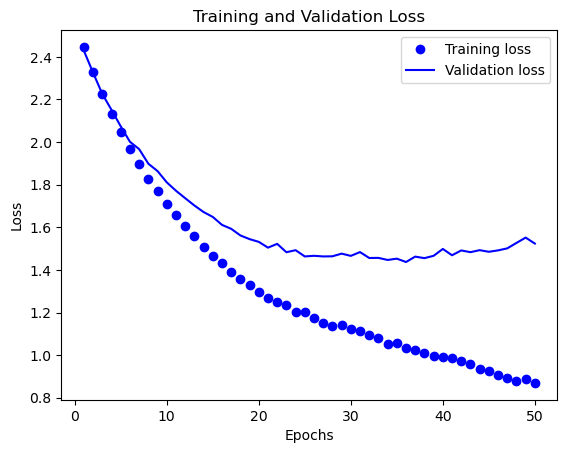

1909.882080078125


In [191]:
# Obter as loss e val_loss do histórico
loss = history.history['loss']
val_loss = history.history['val_loss']

# Criar o gráfico
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

results = model.evaluate(X_test, y_test, verbose = 0)
print(results)

In [192]:
predictions = model.predict(X_test)

# Exibir as probabilidades preditas
print(predictions)

7/7 [==============================] - 0s 1ms/step
[[1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+00 0.000000e+00]
 [1.000000e+00 0.000000e+

Defining and training an LSTM with two layers

In [7]:
model2 = models.Sequential()
model2.add(Embedding(10000, 32))
model2.add(LSTM(32, return_sequences = True))
model2.add(LSTM(32))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model2.summary()

history2 = model2.fit(input_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

history_dict2 = history2.history

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm_2 (LSTM)               (None, None, 32)          8320      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 336,673
Trainable params: 336,673
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
157/157 [==============================] - 74s 447ms/step - loss: 0.6021 - acc: 0.6453 - val_loss: 0.4132 - val_acc: 0.8172
Epoch 2/5
157/157 [===========================

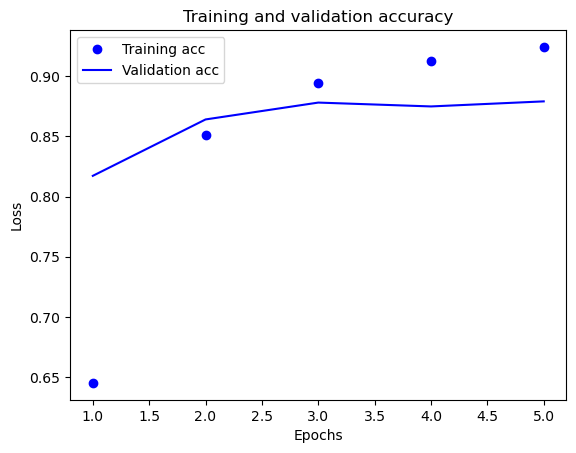

[0.3390980362892151, 0.8729199767112732]


In [8]:
import matplotlib.pyplot as plt
plt.clf()
acc_values = history_dict2['acc'] 
val_acc_values = history_dict2['val_acc']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

results = model2.evaluate(input_test, y_test, verbose = 0)
print(results)

Defining and training a GRU model

In [9]:
from tensorflow.keras.layers import GRU
model3 = models.Sequential()
model3.add(Embedding(10000, 32))
model3.add(GRU(32))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model3.summary()

history3 = model3.fit(input_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

history_dict3 = history3.history

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 326,369
Trainable params: 326,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
157/157 [==============================] - 35s 208ms/step - loss: 0.6324 - acc: 0.6255 - val_loss: 0.4493 - val_acc: 0.7870
Epoch 2/5
157/157 [==============================] - 33s 210ms/step - loss: 0.3688 - acc: 0.8407 - val_loss: 0.3466 - val_acc: 0.8524
Epoch 3/5
157/157 [=========================

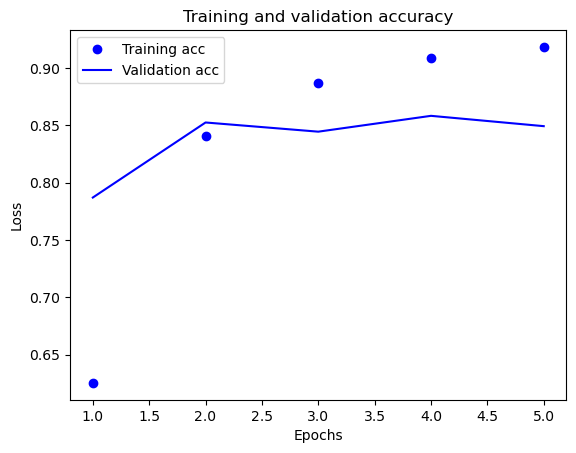

[0.3725026249885559, 0.8449599742889404]


In [10]:
import matplotlib.pyplot as plt
plt.clf()
acc_values = history_dict3['acc'] 
val_acc_values = history_dict3['val_acc']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

results = model3.evaluate(input_test, y_test, verbose = 0)
print(results)

LSTM with Dropout

In [11]:
from tensorflow.keras.layers import Dropout
model4 = models.Sequential()
model4.add(Embedding(10000, 32))
model4.add(LSTM(32, return_sequences = True))
model4.add(Dropout(0.2))
model4.add(LSTM(32))
model4.add(Dropout(0.2))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model4.summary()

history4 = model4.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

history_dict4 = history4.history

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm_4 (LSTM)               (None, None, 32)          8320      
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 336,673
Trainable params: 336,673
Non-tr

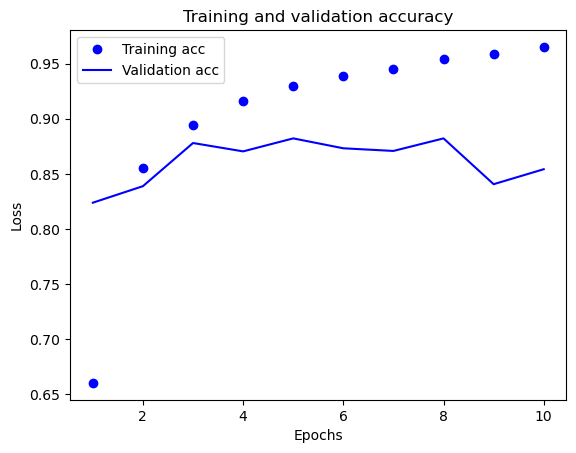

[0.40882375836372375, 0.8518000245094299]


In [12]:
import matplotlib.pyplot as plt
plt.clf()
acc_values = history_dict4['acc'] 
val_acc_values = history_dict4['val_acc']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

results = model4.evaluate(input_test, y_test, verbose = 0)
print(results)